## MACS 30150 Problem Set 7
### Dr. Richard Evans
### Submitted by Junho Choi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline as lsq
from sklearn.linear_model import LogisticRegression as LR
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


\section{Problem 1}

\subsection{1-(a)}

Firstly, let us begin by reading in the data. We can see that, as the question elaborates, there are three levels to our dependent variable `cultivar`.

In [2]:
drink = pd.read_csv('strongdrink.txt')
regressors = drink[['alco', 'malic', 'tot_phen', 'color_int']]
depvar = drink['cultivar']

## checking out the unique values for the dependent variable
depvar.unique()

array([1, 2, 3], dtype=int64)

I first report the coefficients $\beta_{1,0}, \beta_{1,1}, \beta_{1,2}, \beta_{1,3}, \beta_{1,4}, \beta_{2,0}, \beta_{2,1}, \beta_{2,2}, \beta_{2,3}$ and $\beta_{2,4}$ for the model that uses the entire dataset (as opposed to the training and test split). For $j=1$, we have the following (rounded to the nearest hundredth):

$$ (\beta_{1,0}, \beta_{1,1}, \beta_{1,2}, \beta_{1,3}, \beta_{1,4}) = (-23.84, 1.58, -0.14, 1.56, 0.11)$$

For $j=2$, we have the following (rounded to the nearest hundredth):

$$ (\beta_{2,0}, \beta_{2,1}, \beta_{2,2}, \beta_{2,3}, \beta_{2,4}) = (23.37, -1.37, -0.51, 0.49, -1.15)$$

In [3]:
## using the entire set
regr_values = regressors.values
depv_values = depvar.values

multilogit = LR(random_state=0, solver='lbfgs',
                multi_class='multinomial').fit(regr_values, depv_values)
multilogit.intercept_[0:2], multilogit.coef_[0:2]

(array([-23.83624175,  23.37146504]),
 array([[ 1.57968473, -0.14162934,  1.55536396,  0.1092281 ],
        [-1.36779338, -0.50994464,  0.49407356, -1.14580103]]))

Now let us subset the dataset into training and test datasets. As the total number of observations is $176$ and we take 25 percent of it as the test dataset, the number of observations for test data is $44$.

In [4]:
## subsetting into training and testing datasets
X_train, X_test, y_train, y_test = \
    train_test_split(regr_values, depv_values, 
                     test_size = 0.25, random_state=20)
    
X_train.shape, X_test.shape

((132, 4), (44, 4))

After the test-train split, let us train the model. The coefficients are slightly different from the ones from the model using the entire dataset (yet having the same sign), and they are as follows. For $j=1$, we have the following (rounded to the nearest hundredth):

$$ (\beta_{1,0}, \beta_{1,1}, \beta_{1,2}, \beta_{1,3}, \beta_{1,4}) = (-24.03, 1.70, -0.27, 1.22, 0.02)$$

For $j=2$, we have the following (rounded to the nearest hundredth):

$$ (\beta_{2,0}, \beta_{2,1}, \beta_{2,2}, \beta_{2,3}, \beta_{2,4}) = (22.78, -1.47, -0.33, 0.66, -0.92)$$

In [5]:
## training
mlogit_train = LR(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)
mlogit_train.intercept_[0:2], mlogit_train.coef_[0:2]

(array([-24.02761653,  22.7807325 ]),
 array([[ 1.70173443, -0.26578756,  1.22410094,  0.02250699],
        [-1.46629729, -0.33295144,  0.66355615, -0.92268168]]))

Let us now produce the classification report as directed by the question. From the below table, it can be seen that the error rates (i.e. $1-\text{precision}$) are $0.13$, $0.00$, and $0.00$ for $j=1, 2$, and $3$ respectively. The most accurately predicted category (or the category that the model is best at predicting), in terms of precision, recall, and $F1$ score is $j=3$. However, $j=3$ is not the class with the most observations.

In [6]:
## fitting
y_pred = mlogit_train.predict(X_test)

## classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



Let us now calculate the $MSE$. Note that the mean squared error ($MSE$) for categorical variables can be written as follows:
$$\frac{1}{N} \sum_{i=1}^{N} \mathbf{1}_{y_i \neq \hat{y}_i}$$
in which $N$ is the number of observations, and $\mathbf{1}_{y_i \neq \hat{y}_i}$ is the indicator function that equals to $1$ when $y_i \neq \hat{y}_i$ (i.e. the predicted and actual values are not the same) and equals to $0$ when $y_i = \hat{y}_i$ (i.e. the predicted and actual values are the same).

I use the below function `mse_cat` to calculate the $MSE$; the value turns out to be approximately $0.04545$.

In [7]:
def mse_cat(pred, actual):
    
    number_of_obs = pred.shape[0]
    not_eq = (pred != actual)
    summation = not_eq.sum()
    
    return summation / number_of_obs
    
print(mse_cat(y_pred, y_test))

0.0454545454545


\subsection{1-(b)}

Let us now perform the leave-one-out cross-validation (LOOCV). To do so, I define the function `cv_loo_mlogit` for using LOOCV with multinomial logistic regression defined in the question. This will return the $CV_{loo}$ value and the actual and predicted dependent variable values that will be used for calculating the classification report (and error rate, accordingly).

In [8]:
def cv_loo_mlogit(Xvals, yvals, rtn_vectors=True):
    
    print("(1) Printing when actual and predicted values aren't same...")
    print("------------------------------------------------------------")
    
    N = yvals.shape[0]
    xN = Xvals.shape[1]
    
    add_up = 0
    y_pred_vec = np.zeros(N)
    for i in range(N):
        if i == 0:
            X_loo = Xvals[1:]
            y_loo = yvals[1:]
        elif i == N-1:
            X_loo = Xvals[0:N-1]
            y_loo = yvals[0:N-1]
        else:
            X_loo_front, X_loo_back = Xvals[0:i], Xvals[i+1:]
            y_loo_front, y_loo_back = yvals[0:i], yvals[i+1:]
            X_loo = np.vstack((X_loo_front, X_loo_back))
            y_loo = np.hstack((y_loo_front, y_loo_back))
    
        mlogit_loo = LR(random_state=0, solver='lbfgs',
                        multi_class='multinomial').fit(X_loo, y_loo)
        
        X_leftout = np.reshape(Xvals[i], (1, xN))
        loo_pred = mlogit_loo.predict(X_leftout)
        y_pred_vec[i] = loo_pred
        
        if loo_pred[0] != yvals[i]:
            add_up += 1
            print('Observ. #{}:'.format(i), 
                  'Actual Value: {}, Predicted Value: {}'.format(yvals[i], loo_pred[0]))
    
    loo = add_up / N
    print()
    print("(2) CV_LOO = {}".format(loo))
        
    if rtn_vectors:
        return loo, yvals, y_pred_vec
    else:
        return loo

Produced below are the results for the $CV_{loo}$ as well as the cross validation table. The error rates for each category are $0.1$, $0.09$, and $0.04$ for $j=1, 2$ and $3$ respectively. Error rates have decreased for $j=1$, but for $j=2$ and $j=3$ the said rates have increased in comparison to part (a). $LOOCV$ (or $CV_{loo}$) estimate is found to be approximately $0.07955$.

In [9]:
cv_loo, y_actual, y_pred = cv_loo_mlogit(regr_values, depv_values)
print()
print(classification_report(y_actual, y_pred))

(1) Printing when actual and predicted values aren't same...
------------------------------------------------------------
Observ. #23: Actual Value: 1, Predicted Value: 2
Observ. #25: Actual Value: 1, Predicted Value: 2
Observ. #37: Actual Value: 1, Predicted Value: 2
Observ. #38: Actual Value: 1, Predicted Value: 2
Observ. #61: Actual Value: 2, Predicted Value: 3
Observ. #62: Actual Value: 2, Predicted Value: 1
Observ. #66: Actual Value: 2, Predicted Value: 1
Observ. #71: Actual Value: 2, Predicted Value: 1
Observ. #72: Actual Value: 2, Predicted Value: 1
Observ. #83: Actual Value: 2, Predicted Value: 3
Observ. #123: Actual Value: 2, Predicted Value: 1
Observ. #130: Actual Value: 3, Predicted Value: 2
Observ. #134: Actual Value: 3, Predicted Value: 2
Observ. #138: Actual Value: 3, Predicted Value: 1

(2) CV_LOO = 0.07954545454545454

             precision    recall  f1-score   support

          1       0.90      0.93      0.92        59
          2       0.91      0.90      0.91    

\subsection{1-(c)}

Let us now perform the $k$-folds cross validation where $k=4$. To do so, I define the function `cv_kf_mlogit` for using the $k$-folds cross validation with multinomial logistic regression defined in the question. This will return the $CV_{kf}$ value and the actual and predicted dependent variable values that will be used for calculating the classification report (and error rate, accordingly).

In [10]:
def cv_kf_mlogit(Xvals, yvals, k=4, rtn_vectors=True):
    
    ## creating the splits
    kf = KFold(n_splits=k, shuffle=True, random_state=10)
    kf.get_n_splits(Xvals)
    
    ## creating the vector of KFolds MSE
    MSE_vec_kf = np.zeros(k)
    
    k_ind = int(0)
    for train_idx, test_idx in kf.split(Xvals):
        
        ## splitting training and test sets
        X_tr_kf, X_test_kf = Xvals[train_idx], Xvals[test_idx]
        y_tr_kf, y_test_kf = yvals[train_idx], yvals[test_idx]
    
        ## making the prediction
        mlogit_kf = LR(random_state=0, solver='lbfgs',
                       multi_class='multinomial').fit(X_tr_kf, y_tr_kf)
        y_pred_kf = mlogit_kf.predict(X_test_kf)
        
        ## indicator function for categorical variables
        MSE_indicator_kf = (y_pred_kf != y_test_kf).mean()
        
        ## MSE vector for the specific k-fold
        MSE_vec_kf[k_ind] = MSE_indicator_kf
        print('Fold #{}:'.format(k_ind+1), 'MSE is {}'.format(MSE_indicator_kf))

        ## creating the vectors of actual and test yvals
        if k_ind == 0:
            y_act, y_pred = y_test_kf, y_pred_kf
        else:
            y_act = np.hstack((y_act, y_test_kf))
            y_pred = np.hstack((y_pred, y_pred_kf))
        
        k_ind += 1
        
    cv_kf = MSE_vec_kf.mean()
    print('-------------------------------')
    print('CV_KF is {}'.format(cv_kf))
    
    if rtn_vectors:
        return cv_kf, y_act, y_pred
    else:
        return cv_kf

Produced below are the results for the $CV_{kf}$ as well as the cross validation table. The error rates for each category are $0.13$, $0.09$, and $0.04$ for $j=1, 2$ and $3$ respectively. In comparison to part (a), error rate is approximately similar for $j=1$, but for $j=2$ and $j=3$ the said rates have increased. In comparison to part (b), error rates have increased for $j=1$, but remain similar for $j=2$ and $j=3$. $CV_{kf}$ estimate (or $k$-fold estimate) is found to be approximately $0.09091$.

In [11]:
cv_kf, y_actual_kfolds, y_prediction_kfolds \
    = cv_kf_mlogit(regr_values, depv_values, k=4)

print()
print(classification_report(y_actual_kfolds, y_prediction_kfolds))

Fold #1: MSE is 0.1590909090909091
Fold #2: MSE is 0.11363636363636363
Fold #3: MSE is 0.045454545454545456
Fold #4: MSE is 0.045454545454545456
-------------------------------
CV_KF is 0.09090909090909091

             precision    recall  f1-score   support

          1       0.87      0.93      0.90        59
          2       0.91      0.87      0.89        71
          3       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



\section{Problem 2}

\subsection{2-(a)}

In the below code chunk, I have read in the `CoolIndex.txt` data and have successfully produced the scatterplot.

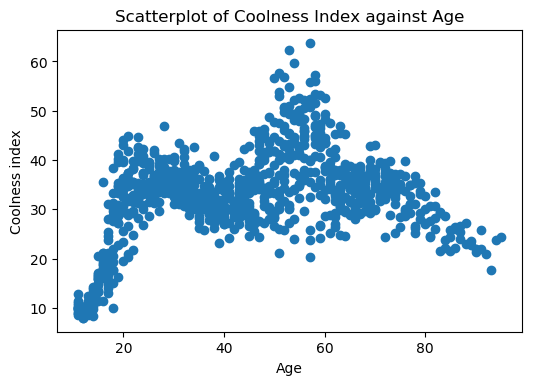

In [12]:
cool = pd.read_csv('CoolIndex.txt', header=None)
plt.figure(num=None, figsize=(6, 4), dpi=100,
           facecolor='w', edgecolor='k')
plt.scatter(cool[0], cool[1])
plt.ylabel('Coolness index')
plt.xlabel('Age')
plt.title('Scatterplot of Coolness Index against Age')
plt.show()

\subsection{2-(b)}

For the OLS regression (to create the stepwise function mentioned in the question), let us first create the dummy variables for each age bin with the $\text{age}\in [11, 22)$ being the base case.

In [13]:
## initializing the dummy variables, with 11<=age<22
## being the base case
cool['22-40'], cool['40-59'], cool['59-77'], cool['77-95'] = 0, 0, 0, 0
cool.loc[(cool[0] < 40) & (cool[0] >= 22), '22-40'] = 1
cool.loc[(cool[0] < 59) & (cool[0] >= 40), '40-59'] = 1
cool.loc[(cool[0] < 77) & (cool[0] >= 59), '59-77'] = 1
cool.loc[(cool[0] <= 95) & (cool[0] >= 77), '77-95'] = 1

We now can create the representations for $X$ (regressors) and $y$ (dependent variable) for the said OLS regression.

In [14]:
X = cool[['22-40', '40-59', '59-77', '77-95']]
X = sm.add_constant(X)
y = cool[[1]]

In the part below, the OLS regression results are produced.

In [15]:
mod_step = sm.OLS(y, X)
res_step = mod_step.fit()
print(res_step.summary())

                            OLS Regression Results                            
Dep. Variable:                      1   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 26 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        21:33:52   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1025      0.562     35.746      0.0

We can now use the above OLS regression results to fit the values of $X$ and produce the stepwise function as shown in the graph below. Since a 73-year old falls under the category of age bin 59-77, we add the constant term $20.1025$ and the coefficient for the said age bin to find out that, under this model, a 73-year old's predicted coolness is approximately $35.2254$.

In [16]:
y_pred_step = res_step.predict(X)

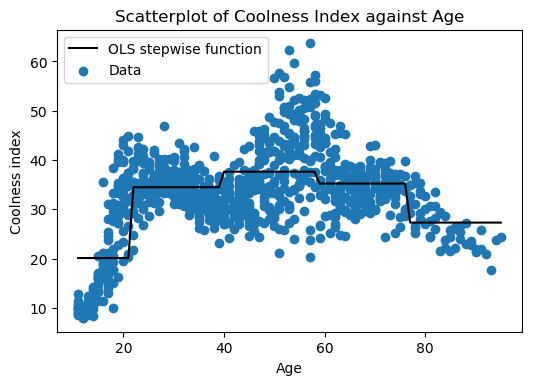

In [17]:
plt.figure(num=None, figsize=(6, 4), dpi=100,
           facecolor='w', edgecolor='k')
plt.scatter(cool[0], cool[1], label='Data')
plt.plot(cool[0], y_pred_step, 'k-', label='OLS stepwise function')
plt.ylabel('Coolness index')
plt.xlabel('Age')
plt.title('Scatterplot of Coolness Index against Age')
plt.legend()
plt.show()

\subsection{2-(c)}

Let us first prepare the set up for the linear spline. Note that to use the function `lsq` (which is the shorthand I use to refer to `LSQUnivariateSpline` throughout this problem set), we need to have a vector of ages where the elements are _strictly_ increasing. Therefore let us take the mean of coolness for each age that appears in the dataset, and use this to create the spline.

In [18]:
## readying for the spline
knots = [22, 40, 59, 77]
mini, maxi = min(cool[0]), max(cool[0])
xs = np.linspace(mini, maxi, 1000)

In [19]:
data = cool[[0, 1]]
data_mean = data.groupby(0).mean()
age = cool[0].unique()
cool_means = data_mean[1]

Below code chunk executes the linear spline.

In [20]:
spl = lsq(x=age, y=cool_means, t=knots, k=1)

Below graph showcases the data points, linear spline and the OLS stepwise function created in part (b). It is visible that, while not very smooth, linear spline resembles the data more so than the OLS stepwise function.

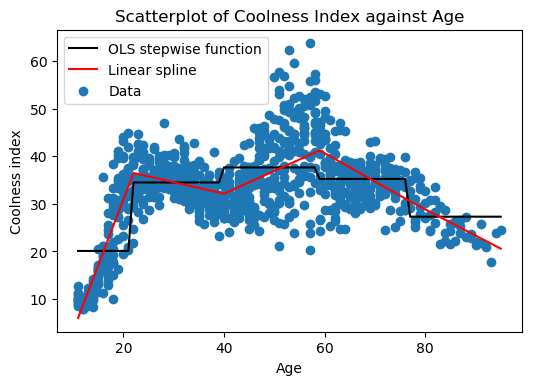

In [21]:
plt.figure(num=None, figsize=(6, 4), dpi=100,
           facecolor='w', edgecolor='k')
plt.scatter(cool[0], cool[1], label='Data')
plt.plot(cool[0], y_pred_step, 'k-', label='OLS stepwise function')
plt.plot(xs, spl(xs), 'r-', label='Linear spline')
plt.ylabel('Coolness index')
plt.xlabel('Age')
plt.title('Scatterplot of Coolness Index against Age')
plt.legend()
plt.show()

Finally, the predicted coolness from the linear spline is approximately $32.8678$ for a 73-year-old.

In [22]:
spl(73)

array(32.86784862349653)

\subsection{2-(d)}

Below code chunk executes the cubic spline.

In [23]:
spl_cube = lsq(x=age, y=cool_means, t=knots, k=3)

Below graph showcases the data points, cubic spline, linear spline from part (c) and the OLS stepwise function created in part (b). It is visible that cubic spline resembles the data more smoothly than the other two.

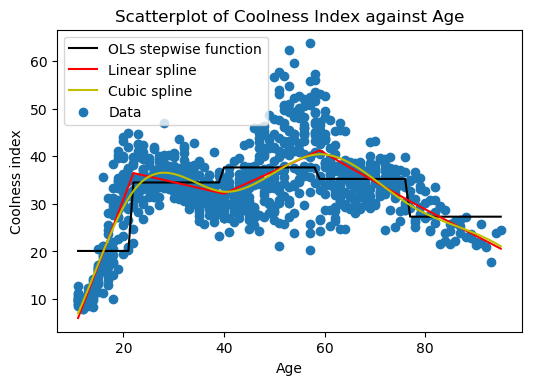

In [24]:
plt.figure(num=None, figsize=(6, 4), dpi=100,
           facecolor='w', edgecolor='k')
plt.scatter(cool[0], cool[1], label='Data')
plt.plot(cool[0], y_pred_step, 'k-', label='OLS stepwise function')
plt.plot(xs, spl(xs), 'r-', label='Linear spline')
plt.plot(xs, spl_cube(xs), 'y-', label='Cubic spline')
plt.ylabel('Coolness index')
plt.xlabel('Age')
plt.title('Scatterplot of Coolness Index against Age')
plt.legend()
plt.show()

Finally, the predicted coolness from the cubic spline is approximately $32.6423$ for a 73-year-old.

In [25]:
spl_cube(73)

array(32.642301066279764)